In [25]:
import subprocess
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import time

Настройки обучения (8 кубит, 4 эпохи, количество слоев):

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_qubits = 8
batch_size = 128
epochs = 4
learning_rate = 0.004

depth_values = [1, 2, 4]   # n_layers (глубина VQC)


Подготовка данных ( Эксперементальная часть продоводиться на наборе данных FashionMNIST: 10 классов одежды, изображения 28x28, 1 канал)

Трансоформер для преобразование данных(преобразование данных в тензор и их нормализация)

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # стандартная нормализация для FashionMNIST
])

Загрузка датасета

In [28]:
train_dataset = datasets.FashionMNIST(
    './data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transform
)

In [29]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [30]:
try:
    import pennylane as qml
except ImportError:
    print("Устанавливаем PennyLane...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pennylane"])
    import pennylane as qml

Квантовое устройство и схема (VQC)

In [31]:

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits)) # AngleEmbedding: кодируем классические признаки в углы вращения кубитов
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits)) # StronglyEntanglingLayers: несколько слоев параметрических вращений и запутывания
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)] # измерение: ожидания PauliZ по каждому кубиту

Гибридная классическая-квантовая модель для задачи классификации.
Модель состоит из:

1.   Двух свёрточных слоев (Conv2d) и одиного полносвязного слой (Linear), который преобразуют входное изображение (28×28) в вектор из n_qubits признаков

2.   Слой TorchLayer интегрирует квантовую схему


In [32]:
class VQCModel(nn.Module):
    def __init__(self, n_qubits=8, n_layers=4):
        super(VQCModel, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers

        # Классическая свёрточная часть (28x28 -> n_qubits признаков)
        self.cl_layer1 = nn.Conv2d(1, 6, 5)   # 1 канал -> 6 карт признаков
        self.pool = nn.MaxPool2d(2, 2)
        self.cl_layer2 = nn.Conv2d(6, 16, 5)  # 6 -> 16
        self.fc_pre = nn.Linear(16 * 4 * 4, n_qubits)

        # Квантовый слой через TorchLayer
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

        # Выходной слой: n_qubits -> 10 классов (одежда)
        self.fc_post = nn.Linear(n_qubits, 10)

    def forward(self, x):
        # Классическое сжатие
        x = self.pool(F.relu(self.cl_layer1(x)))
        x = self.pool(F.relu(self.cl_layer2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc_pre(x)

        # Масштабирование в [-pi, pi] для углов вращения
        x = torch.tanh(x) * np.pi

        # Квантовый слой
        x = self.q_layer(x)

        # Классификация
        x = self.fc_post(x)
        return F.log_softmax(x, dim=1)

Классическая CNN-модель для классификации изображений

In [33]:
class ClassicalModel(nn.Module):
    def __init__(self, n_qubits=8):
        super(ClassicalModel, self).__init__()
        self.n_qubits = n_qubits

        self.cl_layer1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.cl_layer2 = nn.Conv2d(6, 16, 5)
        self.fc_pre = nn.Linear(16 * 4 * 4, n_qubits)

        # Вместо квантового слоя – небольшой MLP
        self.fc_hidden = nn.Linear(n_qubits, n_qubits)
        self.fc_post = nn.Linear(n_qubits, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.cl_layer1(x)))
        x = self.pool(F.relu(self.cl_layer2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc_pre(x))
        x = F.relu(self.fc_hidden(x))
        x = self.fc_post(x)
        return F.log_softmax(x, dim=1)

Обучение. Функция потерь CrossEntripyLoss()

In [39]:
loss_func = nn.CrossEntropyLoss()

def train_one_epoch(model, optimizer, train_loader, device):
    model.train()
    total_loss = 0
    correct = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = total_loss / len(train_loader)
    acc = 100.0 * correct / len(train_loader.dataset)
    return avg_loss, acc

Оценка качества модели на тестовых данных.

In [40]:
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100.0 * correct / len(test_loader.dataset)
    return acc

Оценка "Inception-like score" — метрики

In [41]:
def compute_inception_like_score(model, data_loader, device):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            log_probs = model(data)
            probs = torch.exp(log_probs)
            all_probs.append(probs.cpu())

    all_probs = torch.cat(all_probs, dim=0)
    p_y = all_probs.mean(dim=0, keepdim=True)
    kl = (all_probs * (all_probs.log() - p_y.log())).sum(dim=1)
    is_score = torch.exp(kl.mean())
    return is_score.item()

Обучение + тестирование. Оптимизитор Адам

In [42]:
def train_and_test_model(model, train_loader, test_loader, epochs, device, lr):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    start_time = time.time()
    for epoch in range(1, epochs + 1):
        loss_epoch, acc_epoch = train_one_epoch(model, optimizer, train_loader, device)
        test_acc = evaluate(model, test_loader, device)

        train_loss_hist.append(loss_epoch)
        train_acc_hist.append(acc_epoch)
        test_acc_hist.append(test_acc)

        print(
            f"Эпоха {epoch}: "
            f"loss={loss_epoch:.4f}, train_acc={acc_epoch:.2f}%, test_acc={test_acc:.2f}%"
        )

    total_time = time.time() - start_time
    print(f"Обучение заняло {total_time/60:.2f} минут.")

    # Inception-подобный score на тестовой выборке
    is_score = compute_inception_like_score(model, test_loader, device)
    print(f"Inception-like Score (на FashionMNIST): {is_score:.4f}")

    results = {
        "train_loss": train_loss_hist,
        "train_acc": train_acc_hist,
        "test_acc": test_acc_hist,
        "is_score": is_score,
        "train_time_sec": total_time
    }
    return model, results

Эксперементальная часть

In [43]:
print("Обучение классической модели (baseline) на FashionMNIST")
classical_model = ClassicalModel(n_qubits=n_qubits)
classical_model, classical_results = train_and_test_model(
    classical_model, train_loader, test_loader, epochs, device, learning_rate
)

Обучение классической модели (baseline) на FashionMNIST
Эпоха 1: loss=0.8770, train_acc=66.60%, test_acc=78.59%
Эпоха 2: loss=0.5095, train_acc=81.61%, test_acc=82.29%
Эпоха 3: loss=0.4516, train_acc=83.94%, test_acc=84.89%
Эпоха 4: loss=0.4112, train_acc=85.39%, test_acc=85.37%
Обучение заняло 1.86 минут.
Inception-like Score (на FashionMNIST): 6.5542


In [44]:
vqc_results_by_depth = []

for depth in depth_values:
    print(f"Обучение VQC модели с глубиной n_layers={depth} на FashionMNIST")
    vqc_model = VQCModel(n_qubits=n_qubits, n_layers=depth)
    vqc_model, vqc_results = train_and_test_model(
        vqc_model, train_loader, test_loader, epochs, device, learning_rate
    )
    vqc_results["depth"] = depth
    vqc_results_by_depth.append(vqc_results)

Обучение VQC модели с глубиной n_layers=1 на FashionMNIST
Эпоха 1: loss=1.0371, train_acc=66.67%, test_acc=80.96%
Эпоха 2: loss=0.5808, train_acc=82.41%, test_acc=82.86%
Эпоха 3: loss=0.4901, train_acc=84.46%, test_acc=84.43%
Эпоха 4: loss=0.4472, train_acc=85.53%, test_acc=83.95%
Обучение заняло 4.13 минут.
Inception-like Score (на FashionMNIST): 5.6040
Обучение VQC модели с глубиной n_layers=2 на FashionMNIST
Эпоха 1: loss=1.1158, train_acc=64.43%, test_acc=77.34%
Эпоха 2: loss=0.5836, train_acc=80.81%, test_acc=82.57%
Эпоха 3: loss=0.4877, train_acc=84.11%, test_acc=82.69%
Эпоха 4: loss=0.4486, train_acc=85.24%, test_acc=84.26%
Обучение заняло 5.16 минут.
Inception-like Score (на FashionMNIST): 5.9486
Обучение VQC модели с глубиной n_layers=4 на FashionMNIST
Эпоха 1: loss=1.0415, train_acc=67.08%, test_acc=80.46%
Эпоха 2: loss=0.4960, train_acc=83.49%, test_acc=82.21%
Эпоха 3: loss=0.4301, train_acc=85.33%, test_acc=84.81%
Эпоха 4: loss=0.3901, train_acc=86.51%, test_acc=85.65%
Обуч

Визуализация результата

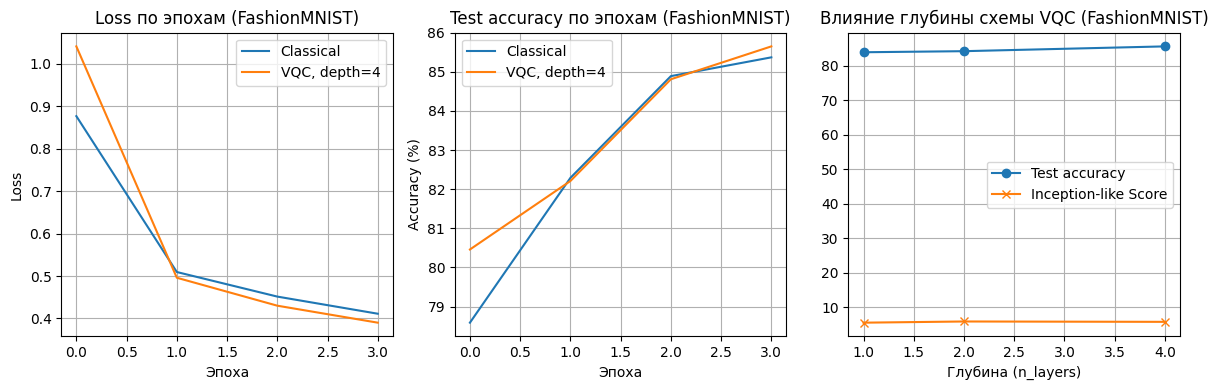

In [45]:
best_vqc = vqc_results_by_depth[-1]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(classical_results["train_loss"], label="Classical")
plt.plot(best_vqc["train_loss"], label=f"VQC, depth={best_vqc['depth']}")
plt.title("Loss по эпохам (FashionMNIST)")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(classical_results["test_acc"], label="Classical")
plt.plot(best_vqc["test_acc"], label=f"VQC, depth={best_vqc['depth']}")
plt.title("Test accuracy по эпохам (FashionMNIST)")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 3)
depths = [r["depth"] for r in vqc_results_by_depth]
test_acc_last = [r["test_acc"][-1] for r in vqc_results_by_depth]
is_scores = [r["is_score"] for r in vqc_results_by_depth]

plt.plot(depths, test_acc_last, marker="o", label="Test accuracy")
plt.plot(depths, is_scores, marker="x", label="Inception-like Score")
plt.title("Влияние глубины схемы VQC (FashionMNIST)")
plt.xlabel("Глубина (n_layers)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()